## Updates
>- Use a model with less parameters than VGG. EfficientNet-B0 uses far less gpu memory than VGG16.
>- Try adabound instead of SGD.
>- Use more or different augmentors on the training set. Used autoaugment(). 
>- Check for imbalance. The training data is not imbalanced
>- Use 10% of train for validation instead of 20%.
>- Added code for early stopping in Train
>- Test accuracy improved from 69% to 77%. (lr = .001, final_lr = .005, 100 epochs)

## Import Statements

In [1]:
import numpy as np
from glob import glob
import cv2                
import matplotlib.pyplot as plt
#from tqdm import tqdm

import torch
from torch import __version__
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import adabound
import time
import timeit
#from efficientnet_pytorch import EfficientNet

from PIL import Image
from PIL import ImageFile

import os
import gc

%matplotlib inline

# use this to temporarily address crashes due to matplotlib and OpenMP
# "OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized."
# see https://knowledge.udacity.com/questions/782100
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Create Loaders (subsample)

In [2]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
#  Borrowed from the Machine Larning Capstone that I completed last year

# define training and test data directories
data_dir = 'landmark_images/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32 #20  changed from 20 to 16 due to experience with the following error when running locally on gpu
                #    RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)
                #    see https://knowledge.udacity.com/questions/782100
# percentage of training set to use as validation
valid_size = 0.1 #0.2 let's reduce the size of the validation set

# convert data to a normalized torch.FloatTensor
transform_train = transforms.Compose([
    transforms.Resize(size=[224,224]),
    transforms.AutoAugment(),
    #transforms.RandomHorizontalFlip(),                                               # random flip
    #transforms.RandomRotation(10),                                                   # random rotation 
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),   # random color jitter
    #transforms.GaussianBlur(kernel_size=(5, 5), sigma=0),                            # random blur
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])  # EfficientNet normalizes for us, so we don't need this
    ])

transform_valid = transforms.Compose([
    transforms.Resize(size=[224,224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],     # EfficientNet normalizes for us, so we don't need this
                             std=[0.229, 0.224, 0.225])
    ])

transform_test = transforms.Compose([
    transforms.Resize(size=[224,224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],     # EfficientNet normalizes for us, so we don't need this
                             std=[0.229, 0.224, 0.225])
    ])

# choose the training and test datasets
train_data = datasets.ImageFolder(train_dir, transform=transform_train)
valid_data = datasets.ImageFolder(train_dir, transform=transform_valid)
test_data  = datasets.ImageFolder(test_dir, transform=transform_test)

# define samplers for obtaining training and validation batches
# since we do not have a seperate valid directory, we will use a subset of training data
num_train = len(train_data)                             # get number of training images
split     = int(np.floor(valid_size*num_train))         # find the split point between train_data and valid_data
indices   = list(range(num_train))                      # compile a list of indices of train_data
np.random.shuffle(indices)                              # shuffle the indices
train_idx, valid_idx = indices[split:], indices[:split] # split the indices into train and valid
train_sampler = SubsetRandomSampler(train_idx)          # sampler for train
valid_sampler = SubsetRandomSampler(valid_idx)          # sampler for valid

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           sampler=train_sampler, 
                                           num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, 
                                           batch_size=batch_size, 
                                           sampler=valid_sampler, 
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, 
                                          num_workers=num_workers)

loaders_transfer = {'train': train_loader,
                    'valid': valid_loader,
                    'test': test_loader}

## Visualize a Sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


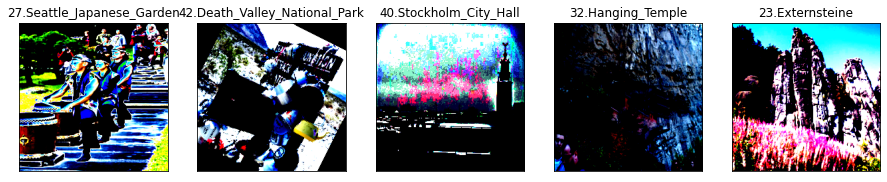

In [3]:
#import matplotlib.pyplot as plt  # moved to top
#%matplotlib inline


## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

# Visualize some sample data

num_images_to_display = 5

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(num_images_to_display): # 20
    ax = fig.add_subplot(1, 8, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(train_data.classes[labels[idx]])

## Check for imbalance

In [4]:
from collections import Counter
print(dict(Counter(train_data.targets)))

# the data is pretty much balanced

{0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100, 7: 100, 8: 100, 9: 100, 10: 100, 11: 100, 12: 100, 13: 100, 14: 100, 15: 100, 16: 100, 17: 100, 18: 100, 19: 100, 20: 100, 21: 100, 22: 100, 23: 100, 24: 100, 25: 100, 26: 100, 27: 100, 28: 100, 29: 100, 30: 100, 31: 100, 32: 100, 33: 100, 34: 100, 35: 100, 36: 100, 37: 100, 38: 100, 39: 100, 40: 100, 41: 100, 42: 100, 43: 100, 44: 100, 45: 100, 46: 100, 47: 100, 48: 100, 49: 96}


## Initialize use_cuda variable

In [5]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Train the Model

In [6]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, early_stopping=10):
    """returns trained model"""

    start1 = timeit.default_timer() 
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    early_stopping_count = 0
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))     

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # update running validation loss 
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))   

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss 
            early_stopping_count = 0
        # add early stopping
        else:
            early_stopping_count += 1

        if early_stopping_count >= early_stopping:
            break
    
    end1 = timeit.default_timer() 
    print("total time: ", end1 - start1)
    
    return model

In [7]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
print(t, r, a, f)

4294967296 0 0 0


## Test the Model

In [8]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

## Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [9]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()

learning_rate_adam = 1e-3
learning_rate_SGD  = 1e-3

def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    #return optim.SGD(model.parameters(), lr=0.05) # from dog_app (Machine Learning Engineer)
    return adabound.AdaBound(model.parameters(), lr=learning_rate_adam, final_lr=learning_rate_SGD)

## Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [10]:
## TODO: Specify model architecture

#model_transfer = models.vgg16(pretrained=True)
model_transfer = models.efficientnet_b0(pretrained=True)

num_classes = len(loaders_transfer['train'].dataset.classes)

# change the last stage of EfficientNet 
in_features = model_transfer.classifier[1].in_features
#model_transfer.classifier[-1] = nn.Linear(in_features=in_features, out_features=num_classes) # set to number of classes
model_transfer.classifier[1]  = nn.Linear(in_features=in_features, out_features=num_classes) # set to number of classes

# keep weights for all layers
for param in model_transfer.parameters():
    param.requires_grad = False
    
# except for the last one. we will optimize it
for param in model_transfer.classifier[1].parameters():
    param.requires_grad = True

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

## Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [11]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
epochs = 250
early_stopping = 20

model_transfer = train(epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                       criterion_transfer, use_cuda, 'model_transfer.pt', early_stopping)

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

C:\Users\wc5257\Anaconda3\envs\tf_gpu_3_torch\lib\site-packages\adabound\adabound.py:94: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:1050.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


Epoch: 1 	Training Loss: 3.547070 	Validation Loss: 3.231034
Validation loss decreased (inf --> 3.231034).  Saving model ...
Epoch: 2 	Training Loss: 3.252223 	Validation Loss: 3.090720
Validation loss decreased (3.231034 --> 3.090720).  Saving model ...
Epoch: 3 	Training Loss: 3.129085 	Validation Loss: 2.971595
Validation loss decreased (3.090720 --> 2.971595).  Saving model ...
Epoch: 4 	Training Loss: 3.041403 	Validation Loss: 2.922219
Validation loss decreased (2.971595 --> 2.922219).  Saving model ...
Epoch: 5 	Training Loss: 2.988817 	Validation Loss: 2.849385
Validation loss decreased (2.922219 --> 2.849385).  Saving model ...
Epoch: 6 	Training Loss: 2.938161 	Validation Loss: 2.808958
Validation loss decreased (2.849385 --> 2.808958).  Saving model ...
Epoch: 7 	Training Loss: 2.898018 	Validation Loss: 2.756655
Validation loss decreased (2.808958 --> 2.756655).  Saving model ...
Epoch: 8 	Training Loss: 2.856725 	Validation Loss: 2.719419
Validation loss decreased (2.75665

Epoch: 78 	Training Loss: 1.937326 	Validation Loss: 1.794334
Validation loss decreased (1.807011 --> 1.794334).  Saving model ...
Epoch: 79 	Training Loss: 1.940116 	Validation Loss: 1.764742
Validation loss decreased (1.794334 --> 1.764742).  Saving model ...
Epoch: 80 	Training Loss: 1.938310 	Validation Loss: 1.816468
Epoch: 81 	Training Loss: 1.925508 	Validation Loss: 1.785144
Epoch: 82 	Training Loss: 1.925864 	Validation Loss: 1.778947
Epoch: 83 	Training Loss: 1.913127 	Validation Loss: 1.747661
Validation loss decreased (1.764742 --> 1.747661).  Saving model ...
Epoch: 84 	Training Loss: 1.904159 	Validation Loss: 1.760175
Epoch: 85 	Training Loss: 1.913331 	Validation Loss: 1.775400
Epoch: 86 	Training Loss: 1.893918 	Validation Loss: 1.740399
Validation loss decreased (1.747661 --> 1.740399).  Saving model ...
Epoch: 87 	Training Loss: 1.883486 	Validation Loss: 1.740473
Epoch: 88 	Training Loss: 1.879379 	Validation Loss: 1.751387
Epoch: 89 	Training Loss: 1.880825 	Valida

Epoch: 173 	Training Loss: 1.598001 	Validation Loss: 1.469088
Epoch: 174 	Training Loss: 1.604634 	Validation Loss: 1.468812
Epoch: 175 	Training Loss: 1.596129 	Validation Loss: 1.458936
Epoch: 176 	Training Loss: 1.571373 	Validation Loss: 1.466371
Epoch: 177 	Training Loss: 1.585842 	Validation Loss: 1.453497
Epoch: 178 	Training Loss: 1.578625 	Validation Loss: 1.464320
Epoch: 179 	Training Loss: 1.591259 	Validation Loss: 1.435547
Validation loss decreased (1.442768 --> 1.435547).  Saving model ...
Epoch: 180 	Training Loss: 1.561885 	Validation Loss: 1.449640
Epoch: 181 	Training Loss: 1.575322 	Validation Loss: 1.434092
Validation loss decreased (1.435547 --> 1.434092).  Saving model ...
Epoch: 182 	Training Loss: 1.561967 	Validation Loss: 1.441704
Epoch: 183 	Training Loss: 1.570110 	Validation Loss: 1.447892
Epoch: 184 	Training Loss: 1.559425 	Validation Loss: 1.438284
Epoch: 185 	Training Loss: 1.551176 	Validation Loss: 1.442763
Epoch: 186 	Training Loss: 1.544248 	Valida

<All keys matched successfully>

In [12]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
print(t, r, a, f)

4294967296 50331648 16791040 33540608


In [13]:
# need to clear up some memory
gc.collect()
torch.cuda.empty_cache

<function torch.cuda.memory.empty_cache() -> None>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [14]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.207362


Test Accuracy: 74% (934/1250)


In [15]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
print(t, r, a, f)

4294967296 538968064 16791040 522177024


In [16]:
# need to clear up some memory
gc.collect()
torch.cuda.empty_cache()

## Landmark Prediction Algorithm

In [17]:
## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

class_names = [item[3:].replace("_", " ")for item in loaders_transfer['train'].dataset.classes]

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    '''
    Use transfer learning VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to the transfer learning VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # NOTE: This code is taken from classifier.py which was part the AI Programming with Python 
    #       Nano degree I completed two years ago. (and also used for Machine Learning Engineer)
    
    
    # load the image
    img_pil = Image.open(img_path)
    
    #Preprocess
    # define transforms
    preprocess = transforms.Compose([
        transforms.Resize(size=[224,224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    
    # preprocess the image
    img_tensor = preprocess(img_pil)
    
    # resize the tensor (add dimension for batch)
    img_tensor.unsqueeze_(0)
    # since we are using a pretrained model and because thge PyTorch version is 0.4, 
    #   we set require_gradient to False. If we are using an earlier version, we will have
    #   to add additional code. 
    img_tensor.requires_grad_(False)
    
    # check for GPU. got errors without this when running on GPU
    if use_cuda:
        img_tensor = img_tensor.cuda()
    
    # puts model in evaluation mode
    # instead of (default)training mode
    output = model_transfer(img_tensor)
    values, pred_idx = output.topk(k)
    # return index corresponding to predicted class
    if use_cuda:
        pred_idx = pred_idx.cpu().data.numpy()
    else:
        pred_idx = pred_idx.data.numpy()

    return pred_idx    


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

array([[ 9, 30, 28, 38, 33]], dtype=int64)

In [18]:
temp = predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

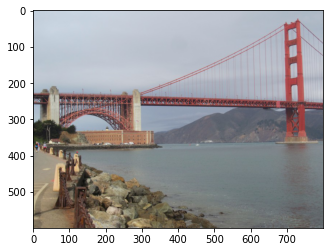

The most likely landmarks are: 1) Golden Gate Bridge  2) Brooklyn Bridge  3) Sydney Harbour Bridge  


In [19]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show(img)
    
    result="The most likely landmarks are: "
    y = 1
    for x in np.nditer(predicted_landmarks):
        result += str(y)+") "+class_names[x]+"  " 
        y += 1
    print(result)    
# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

## Test Your Algorithm

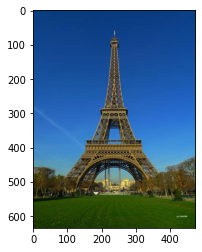

The most likely landmarks are: 1) Eiffel Tower  2) Whitby Abbey  3) Terminal Tower  


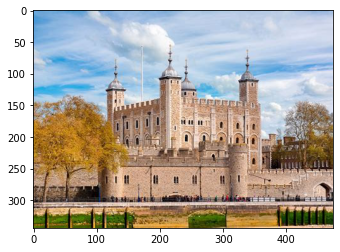

The most likely landmarks are: 1) Edinburgh Castle  2) Vienna City Hall  3) Whitby Abbey  


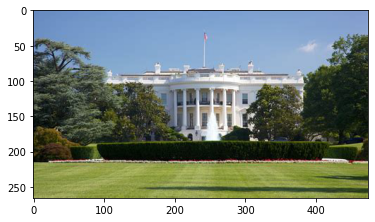

The most likely landmarks are: 1) Stonehenge  2) Temple of Heaven  3) Whitby Abbey  


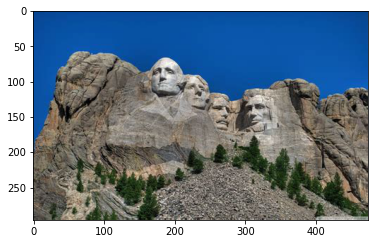

The most likely landmarks are: 1) Mount Rushmore National Memorial  2) Badlands National Park  3) Externsteine  


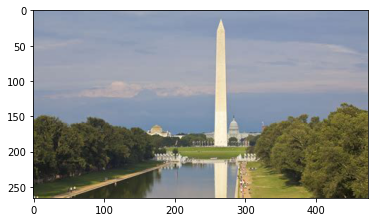

The most likely landmarks are: 1) Washington Monument  2) Stockholm City Hall  3) Golden Gate Bridge  


In [20]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

image_dir = 'images/implement/'
images = ['eiffel_tower.jpg',
          'tower_of_london.jpg',
          'whitehouse.jpg',
          'mount_rushmore.jpg',
          'washington_monument.jpg'
         ]

for image in images:
    image_path = image_dir + image
    suggest_locations(image_path)